# Zarr ECCO ds

In [74]:
from dask.distributed import Client

client = Client("tcp://10.32.5.56:43495")
client

Client Scheduler: tcp://10.32.5.56:43495 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 29 Cores: 58 Memory: 333.50 GB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

In [4]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ecco/eccov4r3'), consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.a

In [5]:
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size: 134.19 GB


In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
#rename time (and iter axis)
dt = dt.rename({'time_snp':'time'})
# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values
#dt.time.values = ds.time.values[1:-1] 
#add nans to dt to change size form 286 to 288

ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

#should I just add nans as first and last value?

In [7]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 1

In [8]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [9]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90

In [10]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'k', 'left': 'k_l', 'outer': 'k_p1', 'right': 'k_u'}})
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic):
  * center   j --> left
  * left     j_g --> center
T Axis (periodic):
  * center   time
Z Axis (periodic):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [11]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where 
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(ds['ADVx_' + suffix], 'X') +
                          grid.diff(ds['ADVy_' + suffix], 'Y')).rename('conv_horiz_adv_flux_' + suffix)
    conv_horiz_diff_flux = -(grid.diff(ds['DFxE_' + suffix], 'X') +
                          grid.diff(ds['DFyE_' + suffix], 'Y')).rename('conv_horiz_diff_flux_' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(ds['ADVr_' + suffix], 'Z', boundary='fill').rename(
                                                        'conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(ds['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(ds['DFrI_' + suffix], 'Z', boundary='fill')).rename(
                                                         'conv_vert_diff_flux_' + suffix)
    
    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    #conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)
    #return xr.merge(all_fluxes + [conv_all_fluxes])
    return xr.merge(all_fluxes)

In [12]:
# sum of all converging adv/diff fluxes
budget_slt = tracer_flux_budget('SLT')
budget_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>

In [13]:
budget_slt.conv_horiz_adv_flux_SLT.data

,Array,Chunk
Bytes,5.60 GB,1.57 MB
Shape,"(288, 50, 270, 360)","(1, 50, 88, 89)"
Count,381602 Tasks,20736 Chunks
Type,float32,numpy.ndarray


In [14]:
budget_th = tracer_flux_budget('TH')
budget_th

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>

In [15]:
#calculating total tendency term for heat
theta_scaled = (ds.THETA_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
theta_scaled

<xarray.DataArray (time_snp: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: k, j, i

In [16]:
#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
theta_scaled = xr.DataArray(theta_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
theta_scaled

<xarray.DataArray 'sub-fbda3ff8be7f33caf9061651bcae0f0a' (time: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [17]:
theta_tend = (theta_scaled / coords.dt[1:287])

In [18]:
#calculating total tendency term for salt
salt_scaled = (ds.SALT_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
salt_scaled
#units: g/kg (psu)

<xarray.DataArray (time_snp: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Dimensions without coordinates: k, j, i

In [19]:
#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
salt_scaled

<xarray.DataArray 'sub-8165ce4238a779d133af308a3811afa4' (time: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [20]:
salt_tend = (salt_scaled / coords.dt[1:287])
#units: g/kg*s (psu/s)

In [21]:
#adding calculated total tendency

volume = (coords.drF * coords.rA * coords.hFacC)
#day2seconds = (24*60*60)

budget_th['total_tendency_TH_truth'] = (theta_tend * volume)
budget_slt['total_tendency_SLT_truth'] = (salt_tend * volume)

In [22]:
budget_th

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(2, 50, 90, 90), meta=np.ndarray>

In [24]:
runit2mass = 1.035e3 #kg/m^3
salt_plume = ((ds.oceSPtnd * coords.rA)/runit2mass)
salt_plume

<xarray.DataArray (time: 288, k: 50, j: 270, i: 360)>
dask.array<truediv, shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: k, j, i

In [27]:
budget_slt['salt_plume'] = salt_plume
budget_slt['surface_flux_SLT'] = surf_flux_slt

In [28]:
budget_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(2, 50, 90, 90), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    surface_flux_SLT          (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

### Surface Fluxes

The surface fluxes are only active in the top model layer. We need to specify some constants to convert to the proper units and scale factors to convert to integral form. They also require some xarray special sauce to merge with the 3D variables.

In [26]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

# treat the shortwave flux separately from the rest of the surface flux
surf_flux_th = (ds.TFLUX - ds.oceQsw) * coords.rA / (heat_capacity_cp * runit2mass)
surf_flux_th_sw = ds.oceQsw * coords.rA / (heat_capacity_cp * runit2mass)
#what about `ds.oceFWflx` term?

# salt
surf_flux_slt = ds.SFLUX * coords.rA  / runit2mass
#units: (˚C m^3)/s

# in order to align the surface fluxes with the rest of the 3D budget terms,
# we need to give them a z coordinate. We can do that with this function
def surface_to_3d(da):
    da.coords['Z'] = ds.Z[0]
    return da.expand_dims(dim='Z', axis=1)

### Shortwave Flux

Special treatment is needed for the shortwave flux, which penetrates into the interior of the water column

In [69]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(k_l=slice(0, 18))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(ds.k_l.sel(k_l=slice(0,18)), surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [71]:
budget_surf_th = xr.merge([surf_flux_th.rename('surface_flux_conv_TH'),
                           (-grid.diff(swdown, 'Z', boundary='fill').fillna(0.)
                           ).rename('sw_flux_conv_TH')])
budget_surf_th

<xarray.Dataset>
Dimensions:               (i: 360, j: 270, k: 18, time: 288)
Coordinates:
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    surface_flux_conv_TH  (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    sw_flux_conv_TH       (time, j, i, k) float32 dask.array<chunksize=(1, 90, 90, 17), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


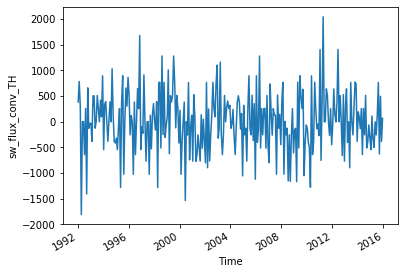

In [75]:
budget_surf_th.sw_flux_conv_TH.sum(dim=['i', 'j', 'k']).plot()